In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

H,W = 150,150
intrinsics = b.Intrinsics(
    height=H,
    width=W,
    fx=200.0, fy=200.0,
    cx=W/2.0, cy=H/2.0,
    near=0.01, far=2.5
)
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh(
    b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.1]))
)
b.RENDERER.add_mesh(
    b.mesh.make_cuboid_mesh(jnp.array([0.01, 0.01, 0.01]))
)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 1024)


In [2]:
contact_plane = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 1.5, 1.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
))


In [3]:
_xy_to_pose = lambda xy: contact_plane @ b.scene_graph.relative_pose_from_edge(
    jnp.array([xy[0], xy[1], 0.0]),
    3,
    b.RENDERER.model_box_dims[0]
)
xy_to_pose = jax.jit(_xy_to_pose)
xy_to_pose_parallel = jax.jit(jax.vmap(_xy_to_pose))

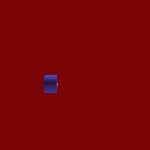

In [4]:
x,y = 0.2, 0.2
observed_img = b.RENDERER.render_single_object(xy_to_pose(jnp.array([x,y])), 0)[:,:,:3]
b.get_depth_image(observed_img[:,:,2])

In [5]:
make_translation_grid_enumeration_2d_jit = jax.jit(b.make_translation_grid_enumeration_2d, static_argnums=(4,5,))
likelihood_parallel_over_images = jax.jit(jax.vmap(
    b.threedp3_likelihood, in_axes=(None, 0, None, None, None, None))
    ,static_argnames=('filter_size',)
)

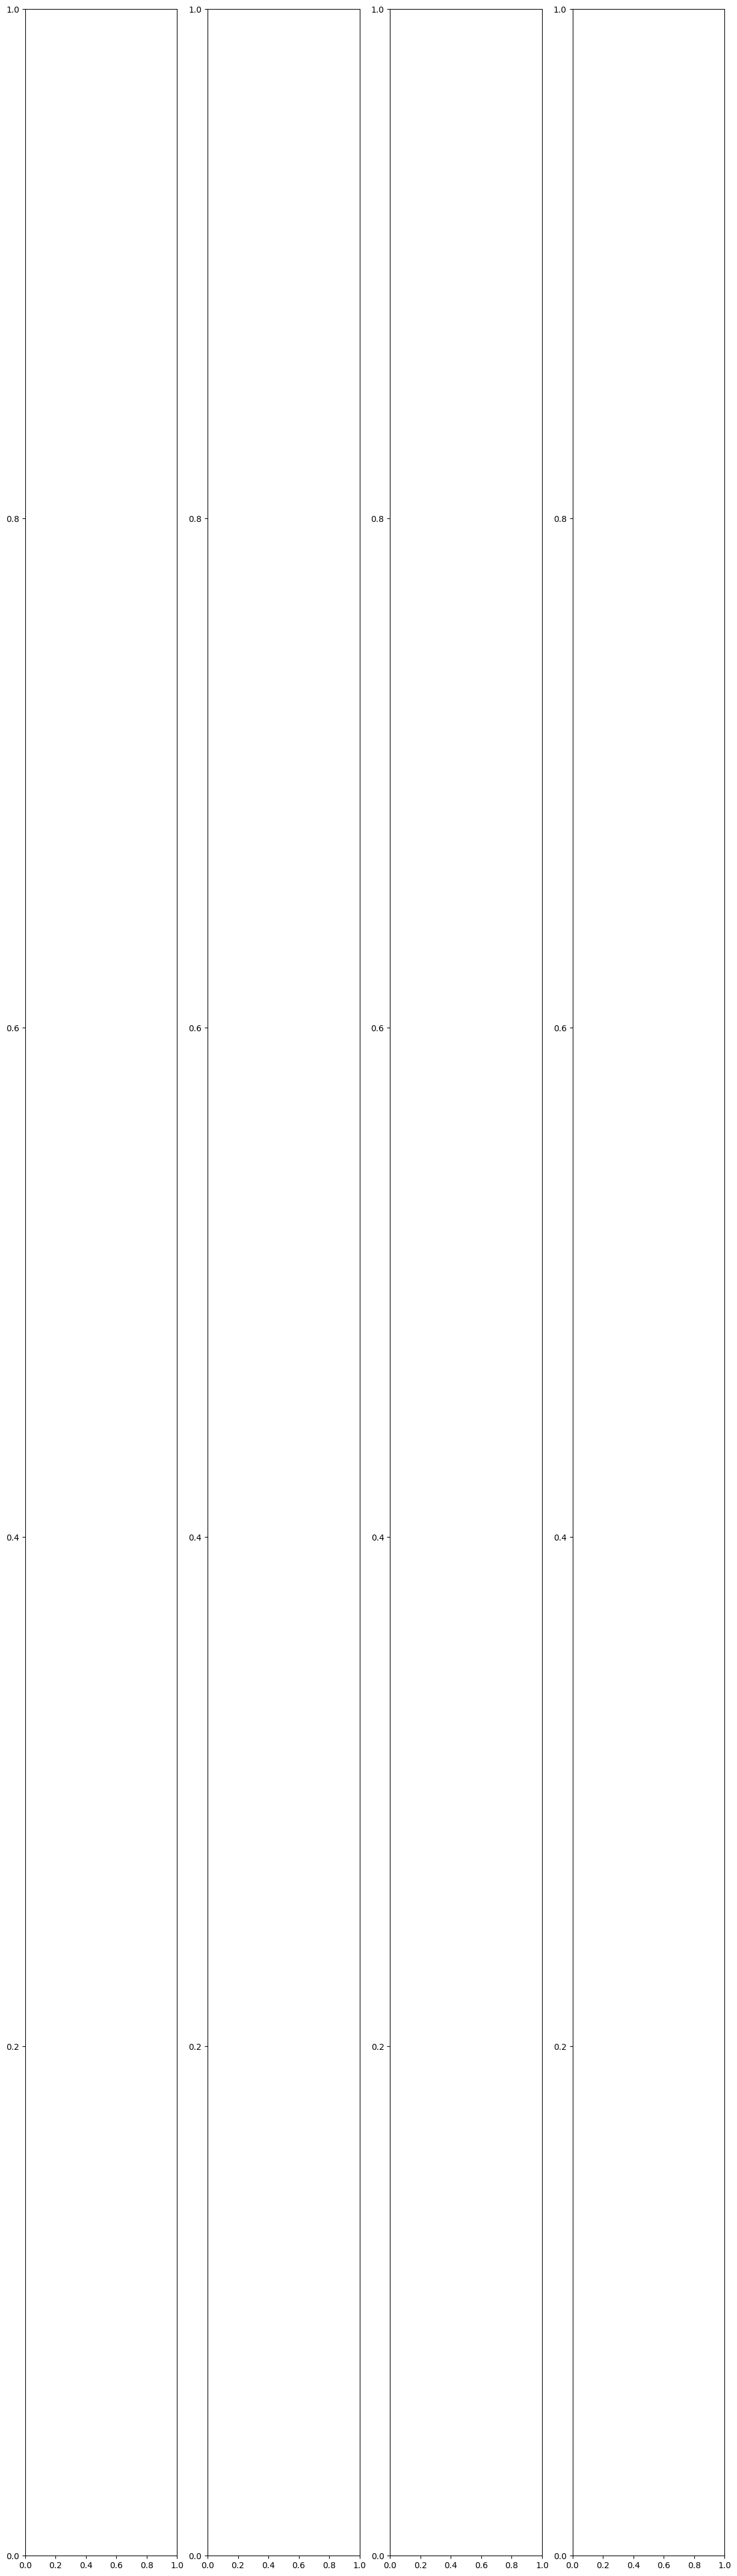

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Button, Output, HBox, VBox, FloatLogSlider

out = Output(layout={'border': '5px solid black', "height" : '100px'})

def func(x,y, grid_width, grid_points, variance, outlier_prob, outlier_volume, filter_size):
    
    observed_img = b.RENDERER.render_single_object(xy_to_pose(jnp.array([x,y])), 0)[:,:,:3]
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 55))
    contact_params = make_translation_grid_enumeration_2d_jit(grid_width, grid_width, -grid_width, -grid_width, grid_points, grid_points)
    poses = xy_to_pose_parallel(contact_params)
    rendered_images = b.RENDERER.render_multiobject_parallel(poses[None,...], [0])

    scores = likelihood_parallel_over_images(observed_img, rendered_images, variance, outlier_prob, outlier_volume, filter_size)
    d = ax[2].pcolormesh(scores.reshape(grid_points, grid_points), edgecolors='k', linewidth=2)
    ax[2].set_aspect('equal')
    ax[2].set_title("Posterior on xy")
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(d, cax=cax, orientation='vertical');

    ax[3].imshow(rendered_images[scores.argmax(),:,:,2])
    ax[3].set_title("Best Reconstruction")

    ax[0].imshow(observed_img[:,:,2])
    ax[0].set_title("Observed Image")
    
    enumeration = b.RENDERER.render_multiobject(poses, [1 for _ in range(len(poses))])
    ax[1].imshow(enumeration[:,:,2])
    
    # prob_not_outlier = b.threedp3_likelihood_per_pixel_jit(observed_img, rendered_images[scores.argmax()], variance, 0.0, 1.0, filter_size)
    # is_outlier = prob_not_outlier < (jnp.log(outlier_prob) - jnp.log(outlier_volume))
    # ax[4].matshow(1.0*is_outlier,vmin=0.0, vmax=1.0)

    
    
    
    with out: 
        out.clear_output()
        display(f"variance   = {variance}")
        display(f"scores.max() = {scores.max()}")

w = interactive(func, 
    x = FloatSlider(min=-1.0, max=1.0, value=0.0, description="observed x:"),
    y = FloatSlider(min=-1.0, max=1.0, value=0.2, description="observed y:"),
    grid_width = FloatSlider(min=0.01, max=1.0, value=0.71, description="grid width:"),
    grid_points = IntSlider(min=1, max=15, step=1, value=14, escription="grid_points :"),
    variance = FloatLogSlider(base=10.0, min=-4, max=2, value=0.003, description="variance:"),
    outlier_prob = FloatSlider(min=0.001, max=0.1, step=0.01,value=0.1, description="outlier_prob:"),
    outlier_volume = FloatLogSlider(base=10.0, min=-4, max=10, step=0.1, value=0.00001, description="outlier_volume:"),
    filter_size = IntSlider(min=0, max=8, step=1, value=8, description='filter_size:'),
);
display(VBox([w,out]))



In [ ]:
-5012.41455078125

In [ ]:
-115375.625